In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

plt.rcParams['figure.figsize'] = [12, 6]

import wandb
from wandb.keras import WandbCallback

In [2]:
time_point_ids = ["hhgat", "maput", "cntsq", "mit", "hynes", "masta", "Wasma", "Melwa", "Dudly"]
date_cols = ["service_date"] + time_point_ids

trip_data = pd.read_csv("../data/one_trips.csv",
                         index_col="half_trip_id", 
                         parse_dates = date_cols)
print(len(trip_data))
trip_data.head()

9078


,service_date,duration,hhgat,maput,cntsq,mit,hynes,masta,Wasma,Melwa,Dudly
half_trip_id,,,,,,,,,,,
46202752.0,2020-01-01,1913,1900-01-01 06:49:49,1900-01-01 06:53:22,1900-01-01 06:58:01,1900-01-01 07:01:52,1900-01-01 07:05:57,1900-01-01 07:12:25,1900-01-01 07:14:42,1900-01-01 07:20:57,1900-01-01 07:21:42
46202754.0,2020-01-01,1294,1900-01-01 07:49:34,1900-01-01 07:53:04,1900-01-01 07:55:01,1900-01-01 07:57:18,1900-01-01 07:59:36,1900-01-01 08:03:12,1900-01-01 08:06:34,1900-01-01 08:10:23,1900-01-01 08:11:08
46202756.0,2020-01-01,1625,1900-01-01 08:57:33,1900-01-01 09:01:42,1900-01-01 09:04:40,1900-01-01 09:09:07,1900-01-01 09:12:35,1900-01-01 09:14:51,1900-01-01 09:18:13,1900-01-01 09:23:52,1900-01-01 09:24:38
46202758.0,2020-01-01,1862,1900-01-01 10:19:20,1900-01-01 10:22:57,1900-01-01 10:26:10,1900-01-01 10:29:26,1900-01-01 10:33:48,1900-01-01 10:38:45,1900-01-01 10:44:08,1900-01-01 10:49:34,1900-01-01 10:50:22
46202760.0,2020-01-01,1935,1900-01-01 11:54:27,1900-01-01 11:59:07,1900-01-01 12:02:49,1900-01-01 12:07:55,1900-01-01 12:13:00,1900-01-01 12:17:51,1900-01-01 12:21:24,1900-01-01 12:26:08,1900-01-01 12:26:42


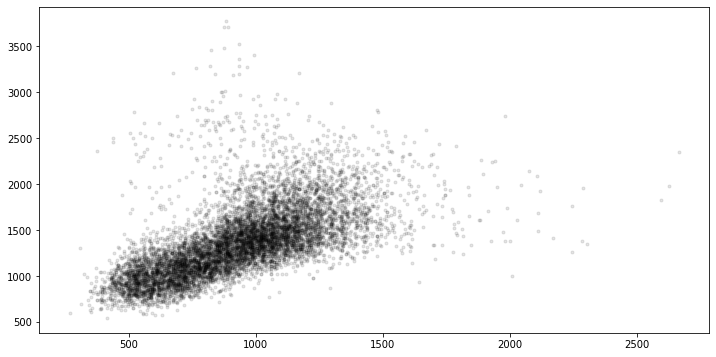

In [3]:
first_half = (trip_data.mit - trip_data.hhgat).dt.seconds
second_half = (trip_data.Dudly - trip_data.mit).dt.seconds
plt.plot(first_half, second_half, ".k", alpha=.1)

In [4]:
total_duration_df = pd.DataFrame({
    "weekday": (trip_data.service_date.dt.weekday < 5).astype('float'),
    "departure": (trip_data.hhgat - pd.to_datetime("1900-01-01")).dt.seconds,
    "duration": trip_data.duration
})
total_duration_df.head()

,weekday,departure,duration
half_trip_id,,,
46202752.0,1.0,24589,1913
46202754.0,1.0,28174,1294
46202756.0,1.0,32253,1625
46202758.0,1.0,37160,1862
46202760.0,1.0,42867,1935


In [5]:
def split_dataset(df, target_col, frac=.7, ):
    train = df.sample(frac=frac)
    test = df.loc[~df.index.isin(train.index)]

    y_train = train.pop(target_col).to_numpy()
    y_test = test.pop(target_col).to_numpy()
    
    x_train = train.to_numpy()
    x_test = test.to_numpy()
    
    return (x_train, y_train), (x_test, y_test)

In [6]:
from tensorflow.keras import layers

def make_model(preprocesser = None):
    
    model = keras.Sequential(
    [
        keras.Input(shape=(2,)),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=1)
    ])
    
    if preprocesser is None:
        return model
    else:
        inputs = keras.Input(shape=(2,))
        x = preprocesser(inputs)
        outputs = model(x)
        return keras.Model(inputs, outputs)

make_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [8]:
def run_duration_prediction(lr=1e-3, debug=False):
    if not debug:
        run = wandb.init(project='bus-predictions')

        config = wandb.config
        config.learning_rate = lr
    
    (x_train, y_train), (x_test, y_test) = split_dataset(total_duration_df, 'duration')
    
    model = make_model(preprocesser=get_preprocesser(x_train))
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr), loss="mean_squared_error")
    
    history = None
    if debug:
        history = model.fit(x_train, y_train, epochs=5,  validation_data=(x_test, y_test), verbose=0)
    else:
        history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), verbose=0, callbacks=[WandbCallback()])

    predictions = model.predict(x_test)
    
    fig = plt.figure(figsize=(8,5))

    departures = x_test[:, 1]
    plt.plot(departures, predictions, ".k", alpha=.3)
    plt.plot(departures, y_test, ".g", alpha=.3)
    
    if debug:
        plt.show()
    else: 
        run.log({"predictions_by_time": wandb.Image(plt)})
        run.finish()

wandb: Currently logged in as: ngd (use `wandb login --relogin` to force relogin)


epoch,49
loss,213132.5625
val_loss,219531.14062
_runtime,32
_timestamp,1615485799
_step,50
best_val_loss,212941.29688
best_epoch,46


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


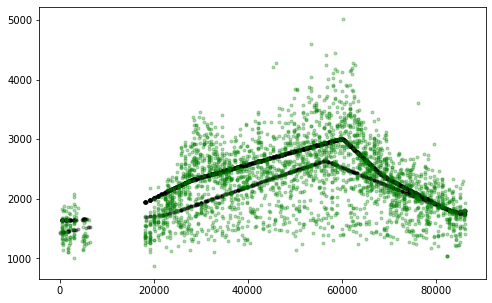

In [9]:
run_duration_prediction(debug=False)

# Second-half duration

In [59]:
prev_stops = ["hhgat", "maput", "cntsq"]
current_stop = "mit"
target_stop = "Dudly"

first_half_df = pd.DataFrame({
    "current_time": trip_data[current_stop],
    "to_target": (trip_data[target_stop] - trip_data[current_stop]).dt.seconds,
    'service_date': trip_data.service_date
})
for prev_stop in prev_stops:
    first_half_df["since_"+prev_stop] = (trip_data[current_stop] - trip_data[prev_stop]).dt.seconds

def get_headways(df, stop):
    df_sorted = df.sort_values(['service_date', stop])
    return df_sorted.current_time.diff()

first_half_df['headway'] = get_headways(first_half_df, 'current_time').dt.seconds
first_half_df['current_time'] = (first_half_df.current_time - pd.to_datetime("1900-01-01")).dt.seconds

ONE_HOT_WEEKDAY = True
if ONE_HOT_WEEKDAY:
    weekdays = ['monday', 'tuesday', 'wednesday', 'thursday','friday', 'saturday','sunday']
    for i, day in enumerate(weekdays):
        first_half_df[day] = (first_half_df.service_date.dt.weekday==i).astype('float')
else:
    first_half_df['weekday'] = (first_half_df.service_date.dt.weekday < 5).astype('float')
del first_half_df['service_date']
    
first_half_df.dropna(inplace=True)
print(len(first_half_df))

first_half_df = first_half_df[["current_time", "headway"]+weekdays+["since_hhgat", "since_maput", "since_cntsq", "to_target"]]

first_half_df.head()

9077


,current_time,headway,monday,tuesday,wednesday,thursday,friday,saturday,sunday,since_hhgat,since_maput,since_cntsq,to_target
half_trip_id,,,,,,,,,,,,,
46202752.0,25312,2385.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,723,510,231,1190
46202754.0,28638,1068.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,464,254,137,830
46202756.0,32947,1158.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,694,445,267,931
46202758.0,37766,969.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,606,389,196,1256
46202760.0,43675,1146.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,808,528,306,1127


In [47]:
def make_model(input_shape, normalize=True, data_sample=None):
    
    model = keras.Sequential([
        keras.Input(shape=input_shape)
    ])
    
    if normalize:
        assert data_sample is not None
        normalizer = layers.experimental.preprocessing.Normalization()
        normalizer.adapt(data_sample)
        model.add(normalizer)
    
    model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dense(units=1))
    
    return model

make_model(input_shape=(2,), normalize=False).summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_61 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_62 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_63 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
398/398 [==============================] - 5s 9ms/step - loss: 1334400.9961 - val_loss: 116554.6484
Epoch 2/50
398/398 [==============================] - 3s 8ms/step - loss: 105107.0824 - val_loss: 97709.6953
Epoch 3/50
398/398 [==============================] - 2s 5ms/step - loss: 92161.9617 - val_loss: 90955.3516
Epoch 4/50
398/398 [==============================] - 2s 5ms/step - loss: 97929.4660 - val_loss: 89454.3047
Epoch 5/50
398/398 [==============================] - 2s 5ms/step - loss: 99113.5466 - val_loss: 87902.5078
Epoch 6/50
398/398 [==============================] - 2s 5ms/step - loss: 88182.8291 - val_loss: 87267.0156
Epoch 7/50
398/398 [==============================] - 2s 5ms/step - loss: 98338.2722 - val_loss: 86870.0391
Epoch 8/50
398/398 [==============================] - 3s 9ms/step - loss: 96165.7006 - val_loss: 86128.7109-
Epoch 9/50
398/398 [==============================] - 2s 5ms/step - loss: 87725.1527 - val_loss: 85157.5781
Epoch 10/50
398/398 [==

epoch,49
loss,60500.52344
val_loss,61133.42188
_runtime,136
_timestamp,1615488465
_step,50
best_val_loss,59643.70312
best_epoch,47


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▄▃▄▃▃▂▂▂▂▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


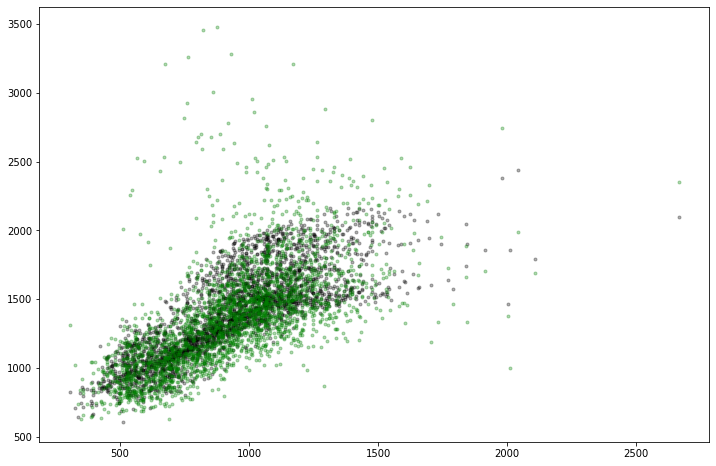

In [48]:
def run_second_half_prediction(lr=1e-3, batch_size=16, debug=False):
    if not debug:
        run = wandb.init(project='bus-predictions-2nd-half')

        config = wandb.config
        config.learning_rate = lr
        config.batch_size = batch_size
    
    (x_train, y_train), (x_test, y_test) = split_dataset(first_half_df, 'to_target')
    
    model = make_model(input_shape=(12,), data_sample=x_train)
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr), loss="mean_squared_error")
        
    fit_args = {
        "x": x_train,
        "y": y_train,
        "validation_data": (x_test, y_test),
        "batch_size": batch_size,
        "epochs": 50,
    }
    if debug:
        fit_args.update({
            "epochs": 5,
        })
    else:
        fit_args.update({
            "callbacks": [WandbCallback()]
        })
    
    history = model.fit(**fit_args)

    fig = plt.figure(figsize=(12,8))
    predictions = model.predict(x_test)
    departures = x_test[:, 1]
    plt.plot(departures, predictions, ".k", alpha=.3)
    plt.plot(departures, y_test, ".g", alpha=.3)
    
    if debug:
        plt.show()
    else: 
        run.log({"predictions_by_time": wandb.Image(plt)})
        run.finish()
        
    return x_test, y_test, predictions

x_test, y_test, predictions = run_second_half_prediction()

r^2:  0.5959608553129611


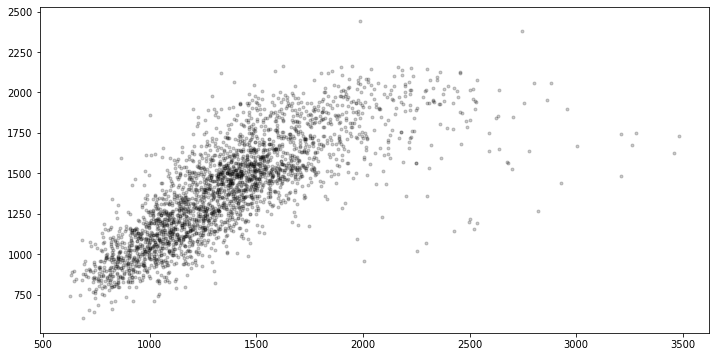

In [49]:
predictions = predictions.reshape(-1)
print("r^2: ", np.corrcoef(y_test, predictions )[0,1]**2)
plt.plot(y_test, predictions, ".k", alpha=.2)

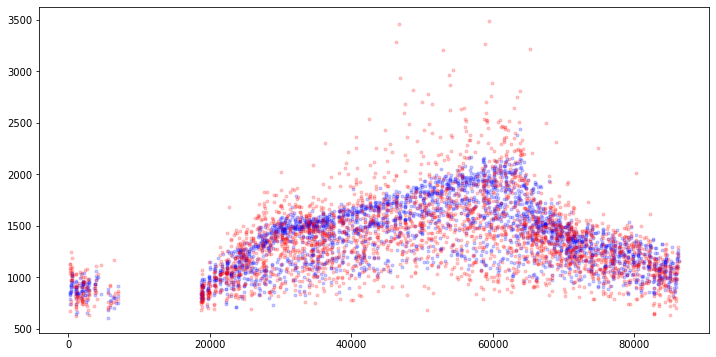

In [52]:
plt.plot(x_test[:,0], predictions, ".b", alpha=.2)
plt.plot(x_test[:,0], y_test, ".r", alpha=.2)

In [104]:
history_input = keras.Input(shape=(None, 1), name="history")
hist_enc = layers.LSTM(units=2)(history_input)

trip_input = keras.Input(shape=(9,), name="trip")

x = layers.concatenate([hist_enc, trip_input])
x = layers.Dense(units=32, activation='relu')(x)
x = layers.Dense(units=32, activation='relu')(x)
x = layers.Dense(units=32, activation='relu')(x)
output = layers.Dense(units=1)(x)

model = keras.Model(
    inputs=[trip_input, history_input],
    outputs=output
)

model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
history (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 2)            32          history[0][0]                    
__________________________________________________________________________________________________
trip (InputLayer)               [(None, 9)]          0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 11)           0           lstm_11[0][0]                    
                                                                 trip[0][0]                

 - Normalization of the history shouldn't be the way it currently is, I think.

In [110]:
debug=True

(x_train, y_train), (x_test, y_test) = split_dataset(first_half_df, 'to_target')

normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(x_train)
x_train = normalizer(x_train)
x_test = normalizer(x_test)

trip_data_train = x_train[:, :9]
hist_data_train = x_train[:, 9:]

trip_data_test = x_test[:, :9]
hist_data_test = x_test[:, 9:]
    
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), loss="mean_squared_error")

fit_args = {
    "x":{"trip": trip_data_train, "history": hist_data_train},
    "y": y_train,
    "validation_data": ({"trip": trip_data_test, "history": hist_data_test}, y_test),
    "batch_size": 16,
    "epochs": 50,
}

history = model.fit(**fit_args)

Epoch 1/50
398/398 [==============================] - 6s 5ms/step - loss: 82385.2309 - val_loss: 76624.9141
Epoch 2/50
398/398 [==============================] - 2s 4ms/step - loss: 81242.9660 - val_loss: 74607.5000
Epoch 3/50
398/398 [==============================] - 1s 4ms/step - loss: 73915.3939 - val_loss: 72961.8203
Epoch 4/50
398/398 [==============================] - 1s 4ms/step - loss: 70571.2468 - val_loss: 71614.7969
Epoch 5/50
398/398 [==============================] - 2s 4ms/step - loss: 73952.3256 - val_loss: 72703.2500
Epoch 6/50
398/398 [==============================] - 2s 4ms/step - loss: 75927.0876 - val_loss: 69427.6328
Epoch 7/50
398/398 [==============================] - 2s 4ms/step - loss: 66444.1947 - val_loss: 67764.8359
Epoch 8/50
398/398 [==============================] - 2s 4ms/step - loss: 63083.1389 - val_loss: 68527.9844
Epoch 9/50
398/398 [==============================] - 2s 4ms/step - loss: 63864.1696 - val_loss: 67878.6953
Epoch 10/50
398/398 [=======

In [111]:
predictions = model.predict({"trip": trip_data_test, "history": hist_data_test})

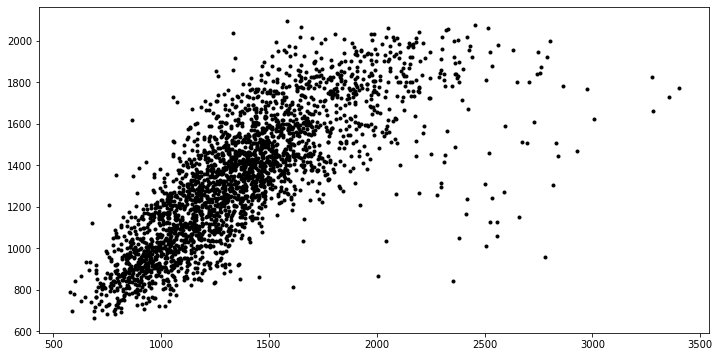

In [112]:
plt.plot(y_test, predictions, ".k")

In [113]:
print("r^2: ", np.corrcoef(y_test, predictions.reshape(-1) )[0,1]**2)

r^2:  0.5760651110433567
